In [1]:
import numpy as np
import os
import sys
import copy

import torch
torch.set_num_threads(os.cpu_count())
from torch import nn

import pickle as pk

import matplotlib as mpl
import matplotlib.pyplot as plt

from pipnet import data
from pipnet import model
from pipnet import utils

np.random.seed(1)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
in_root = f"../../data/1D/"

batch = False
epochs = [1, 50, 100, 150, 200, 250]

# Selecting the 16 best models over 32 trainings
final_epoch = 250
n_epochs = 250

if batch:
    
    out_dir = f"../../data/1D/final_model_batch/"

    models = [
    "PIPNet_2022_10_07_final_model_18_batch",
    "PIPNet_2022_10_07_final_model_29_batch",
    "PIPNet_2022_10_07_final_model_11_batch",
    "PIPNet_2022_10_07_final_model_22_batch",
    "PIPNet_2022_10_07_final_model_25_batch",
    "PIPNet_2022_10_07_final_model_1_batch",
    "PIPNet_2022_10_07_final_model_7_batch",
    "PIPNet_2022_10_07_final_model_17_batch",
    "PIPNet_2022_10_07_final_model_6_batch",
    "PIPNet_2022_10_07_final_model_16_batch",
    "PIPNet_2022_10_07_final_model_15_batch",
    "PIPNet_2022_10_07_final_model_21_batch",
    "PIPNet_2022_10_07_final_model_10_batch",
    "PIPNet_2022_10_07_final_model_24_batch",
    "PIPNet_2022_10_07_final_model_9_batch",
    "PIPNet_2022_10_07_final_model_28_batch",
    "PIPNet_2022_10_07_final_model_31_batch",
    "PIPNet_2022_10_07_final_model_32_batch",
    "PIPNet_2022_10_07_final_model_30_batch",
    "PIPNet_2022_10_07_final_model_12_batch",
    "PIPNet_2022_10_07_final_model_27_batch",
    "PIPNet_2022_10_07_final_model_23_batch",
    "PIPNet_2022_10_07_final_model_3_batch",
    "PIPNet_2022_10_07_final_model_2_batch",
    "PIPNet_2022_10_07_final_model_20_batch",
    "PIPNet_2022_10_07_final_model_19_batch",
    "PIPNet_2022_10_07_final_model_26_batch",
    "PIPNet_2022_10_07_final_model_14_batch",
    "PIPNet_2022_10_07_final_model_13_batch",
    "PIPNet_2022_10_07_final_model_5_batch",
    "PIPNet_2022_10_07_final_model_4_batch",
    ]
else:

    out_dir = f"../../data/1D/final_model/"

    models = [
        "PIPNet_2022_10_06_final_model_11",
        "PIPNet_2022_10_06_final_model_17",
        "PIPNet_2022_10_06_final_model_30",
        "PIPNet_2022_10_06_final_model_4",
        "PIPNet_2022_10_06_final_model_19",
        "PIPNet_2022_10_06_final_model_32",
        "PIPNet_2022_10_06_final_model_12",
        "PIPNet_2022_10_06_final_model_9",
        "PIPNet_2022_10_06_final_model_26",
        "PIPNet_2022_10_06_final_model_1",
        "PIPNet_2022_10_06_final_model_18",
        "PIPNet_2022_10_06_final_model_22",
        "PIPNet_2022_10_06_final_model_10",
        "PIPNet_2022_10_06_final_model_27",
        "PIPNet_2022_10_06_final_model_16",
        "PIPNet_2022_10_06_final_model_28",
        "PIPNet_2022_10_06_final_model_21",
        "PIPNet_2022_10_06_final_model_2",
        "PIPNet_2022_10_06_final_model_3",
        "PIPNet_2022_10_06_final_model_24",
        "PIPNet_2022_10_06_final_model_13",
        "PIPNet_2022_10_06_final_model_29",
        "PIPNet_2022_10_06_final_model_15",
        "PIPNet_2022_10_06_final_model_14",
        "PIPNet_2022_10_06_final_model_8",
    ]

models = models[:16]

loss_jumps = [20, 50]

In [3]:
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

all_data_pars = []
all_model_pars = []
all_losses = []
all_val_losses = []
for mod in models:
    
    with open(f"{in_root}{mod}/data_pars.pk", "rb") as F:
        data_pars = pk.load(F)
    with open(f"{in_root}{mod}/model_pars.pk", "rb") as F:
        model_pars = pk.load(F)
    
    all_losses.append(np.load(f"{in_root}{mod}/all_losses.npy"))
    all_val_losses.append(np.load(f"{in_root}{mod}/all_val_losses.npy"))
        
    all_data_pars.append(data_pars)
    all_model_pars.append(model_pars)

# Check that data and model parameters are compatible

In [4]:
data_keys_to_match = [
    "encode_imag",
    "encode_wr",
    "wr_inv"
]

model_keys_to_match = [
    "input_dim",
    "hidden_dim",
    "kernel_size",
    "num_layers",
    "batch_input",
    "bias",
    "output_bias",
    "return_all_layers",
    "batch_norm",
    "ndim",
    "independent",
    "output_kernel_size",
    "output_act",
    "invert"
]

In [5]:
for i in range(1, len(all_data_pars)):
    for k in data_keys_to_match:
        assert(all_data_pars[0][k] == all_data_pars[i][k])
    for k in model_keys_to_match:
        assert(all_model_pars[0][k] == all_model_pars[i][k])

# Merge models

In [6]:
final_model_pars = all_model_pars[0].copy()
final_model_pars["noise"] = 0.
final_model_pars["n_models"] = len(models)

final_data_pars = all_data_pars[0].copy()

with open(f"{out_dir}data_pars.pk", "wb") as F:
    pk.dump(final_data_pars, F)

with open(f"{out_dir}model_pars.pk", "wb") as F:
    pk.dump(final_model_pars, F)

In [7]:
for epoch in epochs:

    combined_net = model.ConvLSTMEnsemble(**final_model_pars).to(device)
    for i, mod in enumerate(models):
        with open(f"{in_root}{mod}/data_pars.pk", "rb") as F:
            data_pars = pk.load(F)
        with open(f"{in_root}{mod}/model_pars.pk", "rb") as F:
            model_pars = pk.load(F)

        net = model.ConvLSTMEnsemble(**model_pars).to(device)
        net.load_state_dict(torch.load(f"{in_root}{mod}/epoch_{epoch}_network", map_location=device))
        
        combined_net.models[i].load_state_dict(net.models[0].state_dict())
    
    torch.save(combined_net.state_dict(), f"{out_dir}epoch_{epoch}_network")

# Plot loss

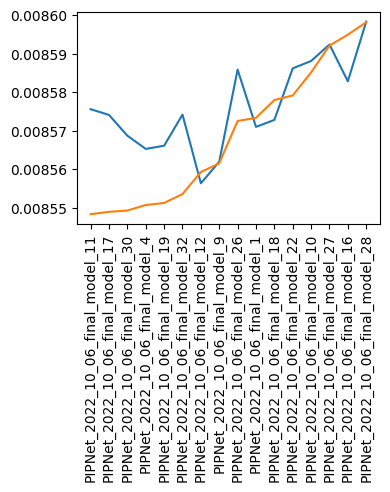

In [8]:
last_n_epochs = 50

last_losses = []
last_val_losses = []

for losses, val_losses in zip(all_losses, all_val_losses):
    
    last_losses.append(np.mean(losses[-last_n_epochs:]))
    last_val_losses.append(np.mean(val_losses[-last_n_epochs:]))

fig = plt.figure(figsize=(4,5))
ax = fig.add_subplot(1,1,1)

ax.plot(range(len(models)), last_losses)
ax.plot(range(len(models)), last_val_losses)

ax.set_xticks(range(len(models)))
ax.set_xticklabels(models, rotation=90)

fig.tight_layout()
plt.show()
plt.close()

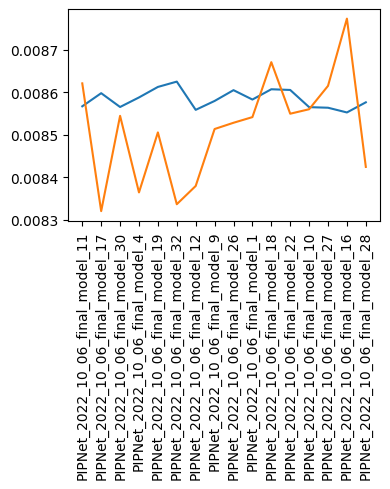

In [9]:
last_n_epochs = 1

last_losses = []
last_val_losses = []

for losses, val_losses in zip(all_losses, all_val_losses):
    
    last_losses.append(np.mean(losses[-last_n_epochs:]))
    last_val_losses.append(np.mean(val_losses[-last_n_epochs:]))

fig = plt.figure(figsize=(4,5))
ax = fig.add_subplot(1,1,1)

ax.plot(range(len(models)), last_losses)
ax.plot(range(len(models)), last_val_losses)

ax.set_xticks(range(len(models)))
ax.set_xticklabels(models, rotation=90)

fig.tight_layout()
plt.show()
plt.close()

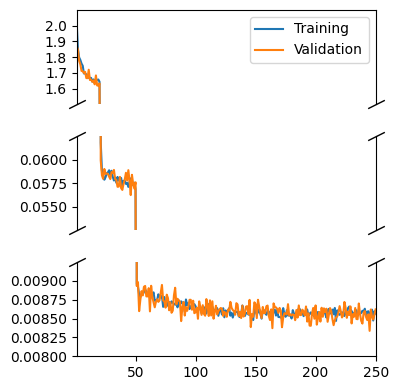

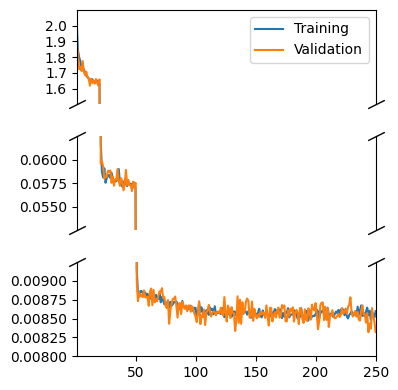

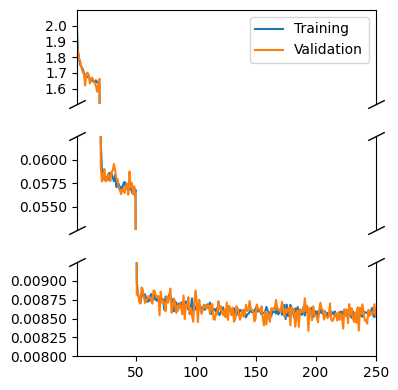

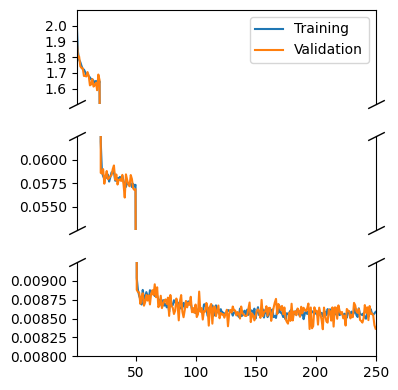

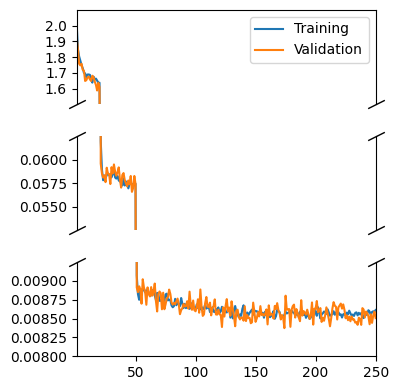

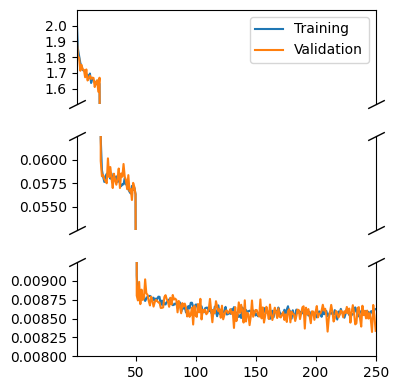

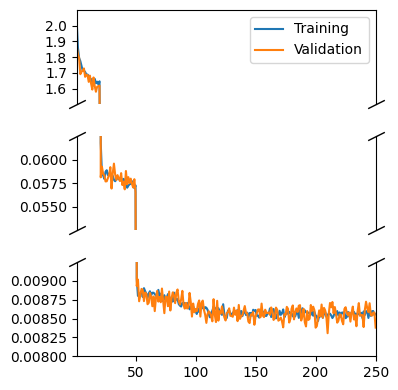

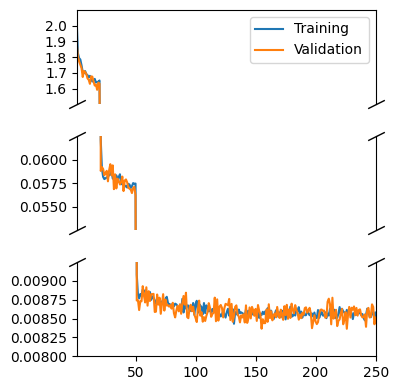

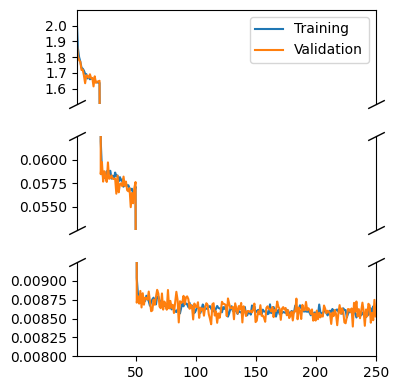

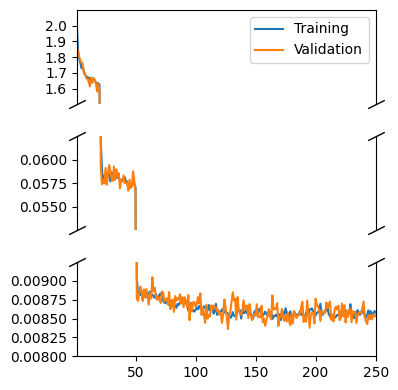

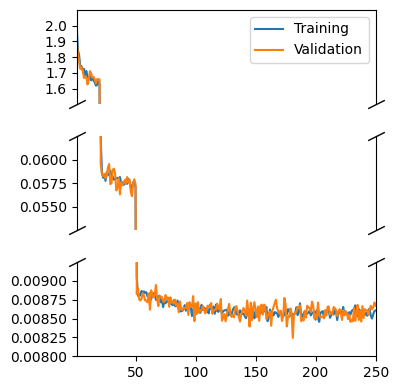

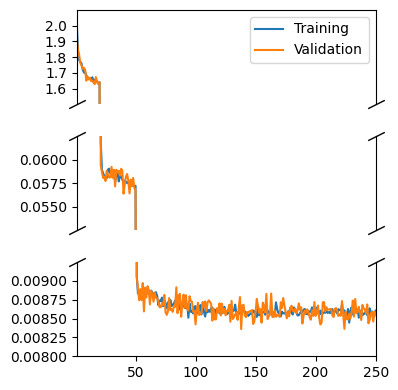

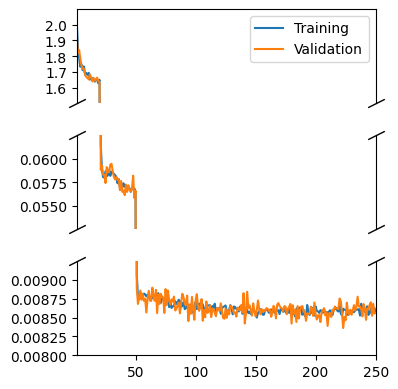

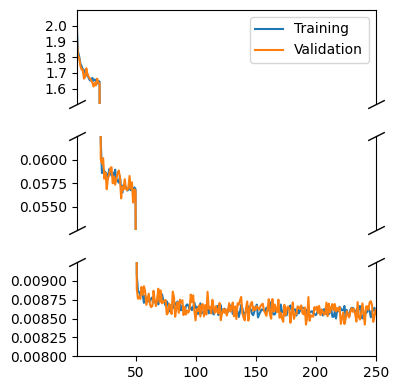

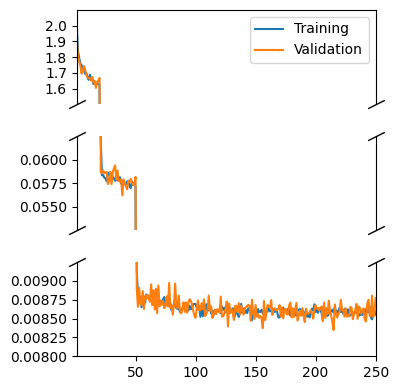

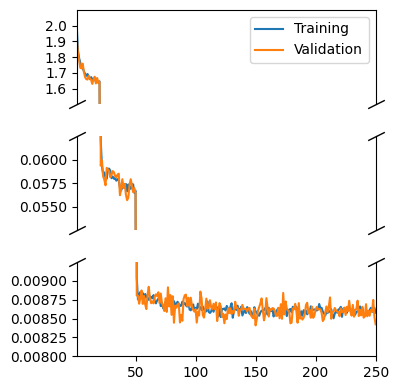

In [10]:
for imod, (losses, val_losses) in enumerate(zip(all_losses, all_val_losses)):
    
    avg_losses = np.mean(losses, axis=1)
    avg_val_losses = np.mean(val_losses, axis=1)

    fig = plt.figure(figsize=(4,4))

    d = 0.5

    axs = []
    for i in range(len(loss_jumps) + 1):
        axs.append(fig.add_subplot(len(loss_jumps)+1, 1,i+1))

        # Plot broken axes markers
        if i > 0:
            axs[i].plot([0, 1], [1, 1], transform=axs[i].transAxes, marker=[(-1, -d), (1, d)],
                        markersize=12, linestyle="none", color="k", mec="k", mew=1, clip_on=False)

            axs[i].spines["top"].set_visible(False)

        if i < len(loss_jumps):
            axs[i].plot([0, 1], [0, 0], transform=axs[i].transAxes, marker=[(-1, -d), (1, d)],
                        markersize=12, linestyle="none", color="k", mec="k", mew=1, clip_on=False)

            axs[i].spines["bottom"].set_visible(False)
            axs[i].set_xticks([])

        h1 = axs[i].plot(range(1, n_epochs+1), avg_losses, "C0")
        h2 = axs[i].plot(range(1, n_epochs+1), avg_val_losses, "C1")
        axs[i].set_xlim(1, n_epochs)

        if i == 0:
            M = np.max(avg_losses[:loss_jumps[i]])
            M = max(M, np.max(avg_val_losses[:loss_jumps[i]]))
            m = np.min(avg_losses[:loss_jumps[i]])
            m = min(M, np.min(avg_val_losses[:loss_jumps[i]]))

        elif i == len(loss_jumps):
            M = np.max(avg_losses[loss_jumps[i-1]:])
            M = max(M, np.max(avg_val_losses[loss_jumps[i-1]:]))
            m = np.min(avg_losses[loss_jumps[i-1]:])
            m = min(m, np.min(avg_val_losses[loss_jumps[i-1]:]))

        else:
            M = np.max(avg_losses[loss_jumps[i-1]:loss_jumps[i]])
            M = max(M, np.max(avg_val_losses[loss_jumps[i-1]:loss_jumps[i]]))
            m = np.min(avg_losses[loss_jumps[i-1]:loss_jumps[i]])
            m = min(m, np.min(avg_val_losses[loss_jumps[i-1]:loss_jumps[i]]))

        r = M - m

        axs[i].set_ylim(m - 0.1 * r, M + 0.1 * r)

    axs[0].legend([h1[0], h2[0]], ["Training", "Validation"])

    fig.tight_layout()

    axs[0].set_yticks([1.6, 1.7, 1.8, 1.9, 2.])
    axs[1].set_yticks([0.055, 0.0575, 0.06])
    axs[2].set_yticks([0.008, 0.00825, 0.0085, 0.00875, 0.009])

    axs[0].set_ylim([1.5, 2.1])
    axs[1].set_ylim([0.0525, 0.0625])
    axs[2].set_ylim([0.008, 0.00925])

    plt.savefig(f"{out_dir}model_{imod}_loss_split.pdf")

    plt.show()
    plt.close()

In [11]:
all_losses = np.concatenate(all_losses, axis=1)
all_val_losses = np.concatenate(all_val_losses, axis=1)

In [12]:
avg_losses = np.mean(all_losses, axis=1)
std_losses = np.std(all_losses, axis=1)
avg_val_losses = np.mean(all_val_losses, axis=1)
std_val_losses = np.std(all_val_losses, axis=1)

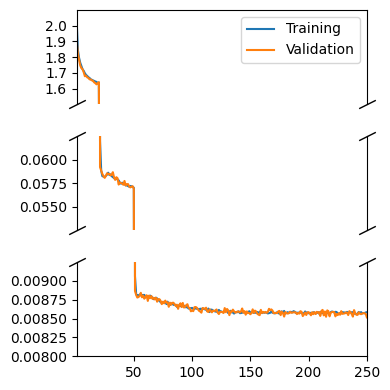

In [13]:
fig = plt.figure(figsize=(4,4))

d = 0.5

axs = []
for i in range(len(loss_jumps) + 1):
    axs.append(fig.add_subplot(len(loss_jumps)+1, 1,i+1))

    # Plot broken axes markers
    if i > 0:
        axs[i].plot([0, 1], [1, 1], transform=axs[i].transAxes, marker=[(-1, -d), (1, d)],
                    markersize=12, linestyle="none", color="k", mec="k", mew=1, clip_on=False)

        axs[i].spines["top"].set_visible(False)

    if i < len(loss_jumps):
        axs[i].plot([0, 1], [0, 0], transform=axs[i].transAxes, marker=[(-1, -d), (1, d)],
                    markersize=12, linestyle="none", color="k", mec="k", mew=1, clip_on=False)

        axs[i].spines["bottom"].set_visible(False)
        axs[i].set_xticks([])

    h1 = axs[i].plot(range(1, n_epochs+1), avg_losses, "C0")
    h2 = axs[i].plot(range(1, n_epochs+1), avg_val_losses, "C1")
    axs[i].set_xlim(1, n_epochs)

    if i == 0:
        M = np.max(avg_losses[:loss_jumps[i]])
        M = max(M, np.max(avg_val_losses[:loss_jumps[i]]))
        m = np.min(avg_losses[:loss_jumps[i]])
        m = min(M, np.min(avg_val_losses[:loss_jumps[i]]))

    elif i == len(loss_jumps):
        M = np.max(avg_losses[loss_jumps[i-1]:])
        M = max(M, np.max(avg_val_losses[loss_jumps[i-1]:]))
        m = np.min(avg_losses[loss_jumps[i-1]:])
        m = min(m, np.min(avg_val_losses[loss_jumps[i-1]:]))

    else:
        M = np.max(avg_losses[loss_jumps[i-1]:loss_jumps[i]])
        M = max(M, np.max(avg_val_losses[loss_jumps[i-1]:loss_jumps[i]]))
        m = np.min(avg_losses[loss_jumps[i-1]:loss_jumps[i]])
        m = min(m, np.min(avg_val_losses[loss_jumps[i-1]:loss_jumps[i]]))

    r = M - m

    axs[i].set_ylim(m - 0.1 * r, M + 0.1 * r)

axs[0].legend([h1[0], h2[0]], ["Training", "Validation"])

fig.tight_layout()

axs[0].set_yticks([1.6, 1.7, 1.8, 1.9, 2.])
axs[1].set_yticks([0.055, 0.0575, 0.06])
axs[2].set_yticks([0.008, 0.00825, 0.0085, 0.00875, 0.009])

axs[0].set_ylim([1.5, 2.1])
axs[1].set_ylim([0.0525, 0.0625])
axs[2].set_ylim([0.008, 0.00925])

plt.savefig(f"{out_dir}all_models_loss_split.pdf")

plt.show()
plt.close()